This notebook is my final submission to [Analytics Vidhya HackLive2](https://datahack.analyticsvidhya.com/contest/hacklive-2-guided-community-hackathon/).   
I have also shown some additional implementations here which were not used for final submission.    
A large part of this notebook is credited to Nikhil's Webinar. I have extended it with additional Feature Engineering and Model Tuning.

#Contents

1. [Mount Drive](#Mount_Drive) 
2. [Import Libraries](#Import_Libraries)
3. [Define Functions](#Define_Functions)
4. [Load Data](#Load_Data)
5. [EDA and Data Preprocessing](#EDA_and_Data_Preprocessing)  
  5.1 [Target Distribution](#Target_Distribution)  
  5.2 [Data Processing](#Data_Processing)  
6. [Model](#Model)    
  6.1 [Linear Regression](#Linear_Regression)  
  6.2 [XGBRegressor](#XGBRegressor)  
  6.3 [LGBMRegressor](#LGBMRegressor)  
  6.4 [CatBoostRegressor](#CatBoostRegressor)  
7. [Feature Engineering](#Feature_Engineering)  
  7.1 [Helper Functions](#Helper_Functions)  
  7.2 [DateTime Features](#DateTime_Features)  
  7.3 [Channel Title](#Channel_Title)  
  7.4 [Views and Comment Counts](#Views_and_Comment_Counts)  
  7.5 [Text Data](#Text_Data)  
  7.6 [NLP](#NLP)      
     7.6.1 [Text Preprocessing](#Text_Preprocessing)  
     7.6.2 [Count](#Count)    
     7.6.3 [Sentiment Analysis](#Sentiment_Analysis)    
     7.6.4 [Capitalized Words](#Capitalized_Words)    
8. [Feature Engineering Models](#Feature_Engineering_Models)  
  8.1 [LGBMRegressor](#FE_LGBMRegressor)  
  8.2 [CatBoostRegressor](#FE_CatBoostRegressor)  
  8.3 [XGBRegressor](#FE_XGBRegressor)  
9. [Model Ensemble](#Model_Ensemble)

#1. Mount Drive <a id = "Mount_Drive"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

from google.colab import files

#2. Import Libraries <a id = "Import_Libraries"></a>

In [ ]:
#Import Libraries

import pandas as pd
import numpy as np

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-dark')

#Data Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

#NLP
from sklearn.feature_extraction.text import CountVectorizer

#Text Processing
import re
import nltk
nltk.download('popular')

#Language Detection
!pip install langdetect
import langdetect

#Sentiment
from textblob import TextBlob

#ner
import spacy

#Vectorizer
from sklearn import feature_extraction, manifold

#Word Embedding
import gensim.downloader as gensim_api

#Topic Modeling
import gensim

#Model
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

!pip install catboost
from catboost import CatBoostRegressor

#Validation
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

#3. Define Functions <a id = "Define_Functions"></a>

In [ ]:
#Hackathon Metric
def predict(model, model_features):
  pred_train = model.predict(X_train[model_features])
  pred_val = model.predict(X_val[model_features])

  print(f"Train RMSLE = {1000 * np.sqrt(mean_squared_error(y_train, pred_train))}")
  print(f"Test RMSLE = {1000 * np.sqrt(mean_squared_error(y_val, pred_val))}")

def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  target = train[TARGET_COL]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[TARGET_COL], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = av_metric(y_val, preds_val)
    print(f'\nAV metric score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = av_metric(target, oofs)
  print(f'\n\nAV metric for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

def av_metric(y_true, y_pred):
  return 1000 * np.sqrt(mean_squared_error(y_true, y_pred))

def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  submission[TARGET_COL] = preds_test

  ## 2. Saving our predictions to a csv file

  submission.to_csv(file_name, index = False)

  ## 3. Downloading and submitting the csv file
  from google.colab import files
  files.download(file_name)

#Download Submission File
def download(model, model_features, file_name = 'hacklive_sub.csv'):

  pred_test = model.predict(test[model_features])
  pred_test = np.expm1(pred_test)

  #Setting the target column with our obtained predictions
  submission[TARGET_COL] = pred_test

  #Saving our predictions to a csv file
  submission.to_csv(file_name, index = False)
  
  #Downloadingthe csv file
  files.download(file_name)

#4. Load Data <a id = "Load Data"></a>

In [ ]:
test = pd.read_csv('/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Data/test.csv')
train = pd.read_csv('/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Data/train.csv')
submission = pd.read_csv('/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Data/sample_submission_cxCGjdN.csv')

ID_COL, TARGET_COL = 'video_id', 'likes'

num_cols = ['views', 'dislikes', 'comment_count']
cat_cols = ['category_id', 'country_code']
text_cols = ['title', 'channel_title', 'tags', 'description']
date_cols = ['publish_date']

# features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]] 

In [ ]:
train.head()

,video_id,title,channel_title,category_id,publish_date,tags,views,dislikes,comment_count,description,country_code,likes
0,53364,Alif Allah Aur Insaan Episode 34 HUM TV Drama ...,HUM TV,24.0,2017-12-12,"HUM|""TV""|""Alif Allah Aur Insaan""|""Episode 34""|...",351430.0,298.0,900.0,Alif Allah Aur Insaan Episode 34 Full - 12 Dec...,CA,2351.0
1,51040,It's Showtime Miss Q & A: Bela gets jealous of...,ABS-CBN Entertainment,24.0,2018-03-08,"ABS-CBN Entertainment|""ABS-CBN""|""ABS-CBN Onlin...",461508.0,74.0,314.0,Vice Ganda notices Bela Padilla's sudden chang...,CA,3264.0
2,1856,ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ \n ಕ್...,SANDALWOOD REVIEWS,24.0,2018-03-26,"challenging star darshan latest news|""challeng...",40205.0,150.0,100.0,ದರ್ಶನ್ ಗೆ ಬಾರಿ ಅವಮಾನ ಮಾಡಿದ ಶಿವಣ್ಣ ನಾಯಕಿ ಕ್ಲ...,IN,580.0
3,22618,Havana - swing cover | dodie feat. FLASHBACK,doddleoddle,10.0,2018-02-21,"havana|""cover""|""a capella""|""swing""|""dodie""|""fl...",509726.0,847.0,4536.0,Hi hi hi! here's our vid on FLASHBACK's channe...,GB,82773.0
4,74074,MUMMY NE NI KEHTA - 2 FT. 102 NOT OUT| DUDE S...,Dude Seriously,23.0,2018-05-10,"dude|""seriously""|""friends""|""fun""|""gujarati""|""h...",74311.0,69.0,161.0,BOOK YOUR TICKETS HERE: https://goo.gl/QxdSyg...,IN,3557.0


#5. EDA and Data Preprocessing <a id = "EDA_and_Data_Preprocessing"></a>

##5.1 Target Distribition <a id = "Target_Distribution"></a>

In [ ]:
#Likes Distribution
_ = df[TARGET_COL].plot(kind = 'density', title = 'Likes Distribution', fontsize=14, figsize=(10, 6))

Target Column is Highly Right Skewed, so we apply log transform.

In [ ]:
#Log Likes Distribution
_ = pd.Series(np.log1p(df[TARGET_COL])).plot(kind = 'density', title = 'Log Likes Distribution', fontsize=14, figsize=(10, 6))

In [ ]:
#Likes Boxplot
_ = df[TARGET_COL].plot(kind = 'box', vert=False, figsize=(12, 4), title = 'Likes Boxplot', fontsize=14)

In [ ]:
#Log Likes BoxPlot
_ = pd.Series(np.log1p(df[TARGET_COL])).plot(kind = 'box', vert=False, figsize=(12, 4), title = 'Likes Boxplot', fontsize=14)

Log Transform helps us to deal with outliers in Target Variable.

##5.2 Data Processing <a id = "Data_Processing"></a>

In [ ]:
#Combine Train and Test set for Data Cleaning
train['set'] = 'train'
test['set'] = 'test'
df = pd.concat([test, train])

#One Hot Encoding
df = pd.get_dummies(df, columns=cat_cols)

#Filling Null Values
df = df.fillna(-999)

#Apply Log Transform to Numerical Columns
df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x: np.log1p(x))

#Separating Train and Test Data
train = df[df['set']=='train']
test = df[df['set']=='test']
train = train.drop('set', 1)
test = test.drop('set', 1)
test = test.drop('likes', 1)

#Define Features
features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in text_cols + date_cols]

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
#Train Test Split
X = train[features]
y = train[TARGET_COL]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 23)

#6. Model <a id = "Model"></a>

##6.1 Linear Regression <a id = "Linear_Regression"></a>

In [ ]:
#Linear Regression
model = LinearRegression()

model.fit(X_train[num_cols], y_train)

predict(model, num_cols)

Train RMSLE = 939.7873508101162
Test RMSLE = 944.3344411130728


In [ ]:
download(model = model, model_features = num_cols, file_name = 's6_lr1.csv')
# !mv s6_lr1.csv '/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Submission Files'

##6.2 XGBRegressor <a id = "XGBRegressor"></a>

In [ ]:
model = XGBRegressor(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(model, fit_params, train, test, cat_num_cols)

In [ ]:
xgb_preds_t = np.expm1(xgb_preds)
download_preds(xgb_preds_t, file_name = 's9_xgb1.csv')
# !mv s9_xgb1.csv '/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Submission Files'

##6.3 LGBMRegressor <a id = "LGBMRegressor"></a>

In [ ]:
model = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf = model, fit_params = fit_params, train = train, test = test, features = cat_num_cols)

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 's7_lgbm2.csv')
!mv s7_lgbm2.csv '/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Submission Files'

##6.4 CatBoostRegressor <a id = "CatBoostRegressor"></a>

In [ ]:
model = CatBoostRegressor(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds, fi = run_gradient_boosting(model, fit_params, train, test, cat_num_cols)

In [ ]:
cb_preds_t = np.expm1(cb_preds)
download_preds(cb_preds_t, file_name = 's8_cb1.csv')
# !mv s8_cb1.csv '/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Submission Files'

#7. Feature Engineering <a id = "Feature_Engineering"></a>

##7.1 Helper Functions <a id = "Helper_Functions"></a>

In [ ]:
test = pd.read_csv('/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Data/test.csv')
train = pd.read_csv('/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Data/train.csv')

def join_df(train, test):

  df = pd.concat([train, test], axis=0).reset_index(drop = True)
  features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
  df[num_cols + ['likes']] = df[num_cols + ['likes']].apply(lambda x: np.log1p(x))

  return df, features

def split_df_and_get_features(df, train_nrows):

  train, test = df[:train_nrows].reset_index(drop = True), df[train_nrows:].reset_index(drop = True)
  features = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
  
  return train, test, features

df, features = join_df(train, test)

cat_cols = ['category_id', 'country_code', 'channel_title']

#Label Encoding
df[cat_cols] = df[cat_cols].apply(lambda x: pd.factorize(x)[0])

##7.2 DateTime Features <a id = "DateTime Features"></a>

In [ ]:
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y-%m-%d')
df['publish_date_days_since_start'] = (df['publish_date'] - df['publish_date'].min()).dt.days

df['publish_date_day_of_week'] = df['publish_date'].dt.dayofweek
df['publish_date_year'] = df['publish_date'].dt.year
df['publish_date_month'] = df['publish_date'].dt.month
df['publish_date_week'] = df['publish_date'].dt.isocalendar().week  

##7.3 Channel Title <a id = "Channel_Title"></a>

In [ ]:
df['channel_title_num_videos'] = df['channel_title'].map(df['channel_title'].value_counts())
df['publish_date_num_videos'] = df['publish_date'].map(df['publish_date'].value_counts())
df['channel_in_n_countries'] = df.groupby('channel_title')['country_code'].transform('nunique')

##7.4 Views and Comment Counts <a id = "Views_and_Comment_Counts"></a>

In [ ]:
#Grouping Features

df['channel_title_mean_views'] = df.groupby('channel_title')['views'].transform('mean')
df['channel_title_max_views'] = df.groupby('channel_title')['views'].transform('max')
df['channel_title_min_views'] = df.groupby('channel_title')['views'].transform('min')

df['channel_title_mean_comments'] = df.groupby('channel_title')['comment_count'].transform('mean')
df['channel_title_max_comments'] = df.groupby('channel_title')['comment_count'].transform('max')
df['channel_title_min_comments'] = df.groupby('channel_title')['comment_count'].transform('min')

df['channel_title_mean_dislikes'] = df.groupby('channel_title')['dislikes'].transform('mean')
df['channel_title_max_dislikes'] = df.groupby('channel_title')['dislikes'].transform('max')
df['channel_title_min_dislikes'] = df.groupby('channel_title')['dislikes'].transform('min')

##7.5 Text Data <a id = "Text_Data"></a>

In [ ]:
df['title_len'] = df['title'].apply(lambda x: len(x))
df['description_len'] = df['description'].apply(lambda x: len(x))
df['tags_len'] = df['tags'].apply(lambda x: len(x))

In [ ]:
TOP_N_WORDS = 50

vec = CountVectorizer(max_features = TOP_N_WORDS)
txt_to_fts = vec.fit_transform(df['description']).toarray()
txt_to_fts.shape

c = 'description'
txt_fts_names = [c + f'_word_{i}_count' for i in range(TOP_N_WORDS)]
df[txt_fts_names] = txt_to_fts

train, test, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

In [ ]:
df.head(1)

,video_id,title,channel_title,category_id,publish_date,tags,views,dislikes,comment_count,description,country_code,likes,publish_date_days_since_start,publish_date_day_of_week,publish_date_year,publish_date_month,channel_title_num_videos,publish_date_num_videos,channel_in_n_countries,channel_title_mean_views,channel_title_max_views,channel_title_min_views,channel_title_mean_comments,channel_title_max_comments,channel_title_min_comments,title_len,description_len,tags_len,description_word_0_count,description_word_1_count,description_word_2_count,description_word_3_count,description_word_4_count,description_word_5_count,description_word_6_count,description_word_7_count,description_word_8_count,description_word_9_count,description_word_10_count,description_word_11_count,...,description_word_13_count,description_word_14_count,description_word_15_count,description_word_16_count,description_word_17_count,description_word_18_count,description_word_19_count,description_word_20_count,description_word_21_count,description_word_22_count,description_word_23_count,description_word_24_count,description_word_25_count,description_word_26_count,description_word_27_count,description_word_28_count,description_word_29_count,description_word_30_count,description_word_31_count,description_word_32_count,description_word_33_count,description_word_34_count,description_word_35_count,description_word_36_count,description_word_37_count,description_word_38_count,description_word_39_count,description_word_40_count,description_word_41_count,description_word_42_count,description_word_43_count,description_word_44_count,description_word_45_count,description_word_46_count,description_word_47_count,description_word_48_count,description_word_49_count,channel_title_mean_dislikes,channel_title_max_dislikes,channel_title_min_dislikes
0,53364,Alif Allah Aur Insaan Episode 34 HUM TV Drama ...,0,0,2017-12-12,"HUM|""TV""|""Alif Allah Aur Insaan""|""Episode 34""|...",12.769769,5.700444,6.803505,Alif Allah Aur Insaan Episode 34 Full - 12 Dec...,0,7.763021,4160,1,2017,12,94,220,2,12.621135,13.660803,11.460505,6.271691,8.29355,4.477337,64,1030,187,0,3,0,2,0,0,1,2,2,0,1,0,...,0,0,0,0,2,1,2,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,1,0,0,7,0,0,0,0,1,1,2,0,0,2,5.166463,6.486161,3.465736


##7.6 NLP <a id = "NLP"></a>

###7.6.1 Text Preprocessing <a id = "Text_Preprocessing"></a>

In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True):

    lst_stopwords = nltk.corpus.stopwords.words("english")
    
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()    
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
#Clean Text

df["clean_title"] = df["title"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, ))
df["clean_tags"] = df["tags"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, ))
df["clean_description"] = df["description"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, ))

###7.6.2 Count <a id = "Count"></a>

In [ ]:
#Word Count
df['clean_title_word_count'] = df["clean_title"].apply(lambda x: len(str(x).split(" ")))
df['clean_tags_word_count'] = df["clean_tags"].apply(lambda x: len(str(x).split(" ")))
df['clean_description_word_count'] = df["clean_description"].apply(lambda x: len(str(x).split(" ")))

#Character Count
df['clean_title_char_count'] = df["clean_title"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['clean_tags_char_count'] = df["clean_tags"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['clean_description_char_count'] = df["clean_description"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

#Sentence Count    
df['clean_description_sentence_count'] = df["clean_description"].apply(lambda x: len(str(x).split(".")))

#Average Word Length
df['clean_title_avg_word_length'] = df['clean_title_char_count'] / df['clean_title_word_count']
df['clean_tags_avg_word_length'] = df['clean_tags_char_count'] / df['clean_tags_word_count']
df['clean_description_avg_word_length'] = df['clean_description_char_count'] / df['clean_description_word_count']

#Average Sentence Length
df['clean_description_avg_sentence_length'] = df['clean_description_word_count'] / df['clean_description_sentence_count']

###7.6.3 Sentiment Analysis <a id = "Sentiment_Analysis"></a>

In [ ]:
#Sentiment Analysis

df["clean_title_sentiment"] = df['clean_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
df["clean_tags_sentiment"] = df['clean_tags'].apply(lambda x: TextBlob(x).sentiment.polarity)
df["clean_description_sentiment"] = df['clean_description'].apply(lambda x: TextBlob(x).sentiment.polarity)

###7.6.4 Capitalized Words <a id = "Capitalized_Words"></a>

In [ ]:
#Capitalized Word

def contains_capitalized_word(s):
    for w in s.split():
        if w.isupper():
            return 1
    return 0

df["clean_title_capital"] = df['clean_title'].apply(contains_capitalized_word)
df["clean_description_capital"] = df['clean_description'].apply(contains_capitalized_word)

In [ ]:
train, test, features = split_df_and_get_features(df, train.shape[0])
features = [c for c in df.columns if c not in [ID_COL, TARGET_COL]]
cat_num_cols = [c for c in features if c not in ['title', 'tags', 'description', 'publish_date']]

#8. Feature Engineering Models <a id = "Feature_Engineering_Models"></a>

##8.1 LGBMRegressor <a id = "FE_LGBMRegressor"></a>


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.51442
[600]	valid_0's rmse: 0.496858
[900]	valid_0's rmse: 0.48875
[1200]	valid_0's rmse: 0.484462
[1500]	valid_0's rmse: 0.482341
[1800]	valid_0's rmse: 0.480705
[2100]	valid_0's rmse: 0.480134
[2400]	valid_0's rmse: 0.479635
[2700]	valid_0's rmse: 0.479254
[3000]	valid_0's rmse: 0.47913
[3300]	valid_0's rmse: 0.478738
[3600]	valid_0's rmse: 0.478547
[3900]	valid_0's rmse: 0.478438
[4200]	valid_0's rmse: 0.478297
[4500]	valid_0's rmse: 0.478257
Early stopping, best iteration is:
[4557]	valid_0's rmse: 0.478234

AV metric score for validation set is 478.23437129895126

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[300]	valid_0's rmse: 0.50767
[600]	valid_0's rmse: 0.491596
[900]	valid_0's rmse: 0.485274
[1200]	valid_0's rmse: 0.481869
[1500]	valid_0's rmse: 0.480365
[1800]	valid_0's rmse: 0.478885
[2100]	valid_0'

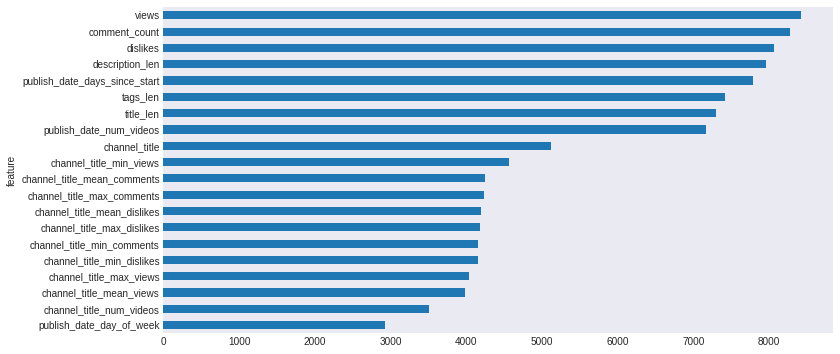

In [ ]:
model = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,    
                        colsample_bytree = 0.65,
                        metric = 'None',
                        num_leaves = 50, 
                       
                       )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds_50, fi = run_gradient_boosting(model, fit_params, train, test, cat_num_cols)

In [ ]:
lgb_preds_t = np.expm1(lgb_preds)
download_preds(lgb_preds_t, file_name = 's27 _lgbm_featureEng_colsample0.75.csv')    
# !mv s27_lgbm_featureEng_colsample0.75.csv '/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Submission Files'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##8.2 CatBoostRegressor <a id = "FE_CatBoostRegressor"></a>

In [ ]:
model = CatBoostRegressor(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds, fi = run_gradient_boosting(model, fit_params, train, test, cat_num_cols)

In [ ]:
cb_preds_t = np.expm1(cb_preds)
download_preds(cb_preds_t, file_name = 's11_cb_featureEng.csv')
# !mv s11_cb_featureEng.csv '/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Submission Files'

##8.3 XGBRegressor <a id = "FE_XGBRegressor"></a>

In [ ]:
model = XGBRegressor(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds, fi = run_gradient_boosting(model, fit_params, train, test, cat_num_cols)

In [ ]:
xgb_preds_t = np.expm1(xgb_preds)    
download_preds(xgb_preds_t, file_name = 's28_xgb_featureEng.csv')
# !mv s28_xgb_featureEng.csv '/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Submission Files'

#9. Model Ensemble <a id = "Model_Ensemble"></a>

In [ ]:
test = pd.read_csv('/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Data/test.csv')
train = pd.read_csv('/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Data/train.csv')

In [ ]:
train_new = train[[ID_COL, TARGET_COL]]
train_new[TARGET_COL] = np.log1p(train_new[TARGET_COL])

test_new = test[[ID_COL]]

train_new['lgb'] = lgb_oofs
test_new['lgb'] = lgb_preds

train_new['cb'] = cb_oofs
test_new['cb'] = cb_preds

train_new['xgb'] = xgb_oofs
test_new['xgb'] = xgb_preds

features = [c for c in train_new.columns if c not in [ID_COL, TARGET_COL]]

In [ ]:
model = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.05,
                        colsample_bytree = 0.65,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

ens_oofs, ens_preds, fi = run_gradient_boosting(model, fit_params, train_new, test_new, features)

In [ ]:
ens_preds_t = np.expm1(ens_preds)
download_preds(ens_preds_t, file_name = 's13_ens1.csv')
# !mv s13_ens1.csv '/content/MyDrive/My Drive/Data Science/Analytics Vidhya/Hacklive 2 Guided Community Hackathon/Submission Files'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>